# TIMM Feature Extraction and k-NN Graph Construction for SVHN/CIFAR10

This notebook demonstrates how to use TIMM (PyTorch Image Models) for feature extraction from SVHN and CIFAR10 datasets, followed by k-NN graph construction for downstream analysis.

## 🚀 Environment Setup

**Important**: This notebook requires the `torch-multimodal` conda environment.

### Option 1: Using the setup script
```bash
./setup_notebook_env.sh
```

### Option 2: Manual setup
```bash
# Activate environment
conda activate torch-multimodal

# Install Jupyter kernel
conda install -y ipykernel
python -m ipykernel install --user --name torch-multimodal --display-name "Python (torch-multimodal)"

# Start Jupyter
jupyter notebook timm_knn_features.ipynb
```

### Option 3: Direct run with environment
```bash
conda activate torch-multimodal && jupyter notebook timm_knn_features.ipynb
```

Then in the notebook: **Kernel → Change kernel → Python (torch-multimodal)**

## 1. Setup and Imports

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import networkx as nx
from scipy.sparse import csr_matrix
import pandas as pd
from typing import Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(f"Using device: {device}")

Using device: mps


## 2. Data Loading Functions

In [13]:
def get_data_transforms():
    """Get standard transforms for CIFAR10/SVHN compatible with TIMM models"""
    return transforms.Compose([
        transforms.Resize(224),  # TIMM models expect 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
    ])

def load_cifar10(batch_size=64, train=False, max_samples=2000):
    """Load CIFAR10 dataset"""
    transform = get_data_transforms()
    dataset = torchvision.datasets.CIFAR10(
        root='/Users/tanmoy/research/data', train=train, download=True, transform=transform
    )
    
    # Subsample if needed
    if max_samples and len(dataset) > max_samples:
        indices = np.random.choice(len(dataset), max_samples, replace=False)
        dataset = torch.utils.data.Subset(dataset, indices)
    
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

def load_svhn(batch_size=64, split='test', max_samples=2000):
    """Load SVHN dataset"""
    transform = get_data_transforms()
    dataset = torchvision.datasets.SVHN(
        root='/Users/tanmoy/research/data', split=split, download=True, transform=transform
    )
    
    # Subsample if needed
    if max_samples and len(dataset) > max_samples:
        indices = np.random.choice(len(dataset), max_samples, replace=False)
        dataset = torch.utils.data.Subset(dataset, indices)
    
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## 3. TIMM Feature Extractor Class

In [14]:
class TIMMFeatureExtractor:
    """Feature extractor using TIMM models"""
    
    def __init__(self, model_name='resnet50', pretrained=True):
        self.model_name = model_name
        self.device = device
        
        # Load TIMM model without classification head (num_classes=0)
        print(f"Loading {model_name} from TIMM...")
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        self.model.eval()
        self.model.to(self.device)
        
        # Get feature dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224).to(self.device)
            dummy_output = self.model(dummy_input)
            self.feature_dim = dummy_output.shape[1]
        
        print(f"Model loaded. Feature dimension: {self.feature_dim}")
    
    def extract_features(self, dataloader, max_samples=None):
        """Extract features from dataloader"""
        features = []
        labels = []
        
        print(f"Extracting features using {self.model_name}...")
        
        with torch.no_grad():
            sample_count = 0
            for batch_idx, (data, target) in enumerate(dataloader):
                if max_samples and sample_count >= max_samples:
                    break
                
                data = data.to(self.device)
                
                # Extract features
                batch_features = self.model(data)
                
                features.append(batch_features.cpu().numpy())
                labels.extend(target.numpy())
                sample_count += len(data)
                
                if batch_idx % 10 == 0:
                    print(f"  Processed {sample_count} samples...")
        
        features_array = np.vstack(features)
        labels_array = np.array(labels)
        
        print(f"✅ Extracted features shape: {features_array.shape}")
        return features_array, labels_array

## 4. k-NN Graph Construction

In [15]:
class KNNGraphBuilder:
    """Build k-NN graphs from feature representations"""
    
    def __init__(self, k_neighbors=10, metric='cosine'):
        self.k_neighbors = k_neighbors
        self.metric = metric
        self.scaler = StandardScaler()
        
    def build_knn_graph(self, features, normalize_features=True):
        """Build k-NN graph from features"""
        print(f"Building k-NN graph with k={self.k_neighbors}, metric={self.metric}")
        
        # Normalize features if requested
        if normalize_features:
            features_norm = self.scaler.fit_transform(features)
        else:
            features_norm = features
        
        # Build k-NN graph using scikit-learn
        knn_graph = kneighbors_graph(
            features_norm, 
            n_neighbors=self.k_neighbors,
            metric=self.metric,
            mode='connectivity',  # Binary adjacency matrix
            include_self=False
        )
        
        # Make graph symmetric
        knn_graph = 0.5 * (knn_graph + knn_graph.T)
        
        print(f" k-NN graph built: {knn_graph.shape[0]} nodes, {knn_graph.nnz} edges")
        return knn_graph
    
    def compute_graph_properties(self, graph):
        """Compute basic graph properties"""
        # Convert to NetworkX for analysis
        G = nx.from_scipy_sparse_matrix(graph)
        
        properties = {
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges(),
            'density': nx.density(G),
            'num_connected_components': nx.number_connected_components(G),
        }
        
        # Compute average clustering if graph is not too large
        if G.number_of_nodes() <= 1000:
            properties['avg_clustering'] = nx.average_clustering(G)
        else:
            properties['avg_clustering'] = 'N/A (graph too large)'
        
        return properties
    
    def get_distance_matrix(self, features, normalize_features=True):
        """Compute pairwise distance matrix"""
        if normalize_features:
            features_norm = self.scaler.fit_transform(features)
        else:
            features_norm = features
            
        # Use NearestNeighbors to compute distances
        nn = NearestNeighbors(metric=self.metric, n_jobs=-1)
        nn.fit(features_norm)
        
        distances, indices = nn.kneighbors(
            features_norm, n_neighbors=min(self.k_neighbors + 1, len(features_norm))
        )
        
        return distances, indices

## 5. Visualization Functions

In [16]:
def visualize_features_2d(features, labels, method='tsne', title="Feature Visualization"):
    """Visualize high-dimensional features in 2D"""
    print(f"Reducing dimensions using {method.upper()}...")
    
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    elif method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")
    
    # Subsample for visualization if too many points
    if len(features) > 2000:
        indices = np.random.choice(len(features), 2000, replace=False)
        features_vis = features[indices]
        labels_vis = labels[indices]
    else:
        features_vis = features
        labels_vis = labels
    
    # Reduce dimensions
    features_2d = reducer.fit_transform(features_vis)
    
    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_vis, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(f"{title} ({method.upper()})")
    plt.xlabel(f"{method.upper()} 1")
    plt.ylabel(f"{method.upper()} 2")
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_graph_properties(properties_dict):
    """Plot graph properties comparison"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    datasets = list(properties_dict.keys())
    
    # Number of edges
    edges = [properties_dict[d]['num_edges'] for d in datasets]
    axes[0, 0].bar(datasets, edges)
    axes[0, 0].set_title('Number of Edges')
    axes[0, 0].set_ylabel('Count')
    
    # Graph density
    densities = [properties_dict[d]['density'] for d in datasets]
    axes[0, 1].bar(datasets, densities)
    axes[0, 1].set_title('Graph Density')
    axes[0, 1].set_ylabel('Density')
    
    # Connected components
    components = [properties_dict[d]['num_connected_components'] for d in datasets]
    axes[1, 0].bar(datasets, components)
    axes[1, 0].set_title('Connected Components')
    axes[1, 0].set_ylabel('Count')
    
    # Average clustering (if available)
    clustering = [properties_dict[d]['avg_clustering'] if isinstance(properties_dict[d]['avg_clustering'], (int, float)) else 0 for d in datasets]
    axes[1, 1].bar(datasets, clustering)
    axes[1, 1].set_title('Average Clustering Coefficient')
    axes[1, 1].set_ylabel('Coefficient')
    
    plt.tight_layout()
    plt.show()

def plot_distance_distributions(distances_dict):
    """Plot k-NN distance distributions"""
    plt.figure(figsize=(12, 6))
    
    for i, (dataset_name, distances) in enumerate(distances_dict.items()):
        plt.subplot(1, len(distances_dict), i+1)
        
        # Plot histogram of distances to nearest neighbors
        all_distances = distances[:, 1:].flatten()  # Exclude self-distance (first column)
        plt.hist(all_distances, bins=50, alpha=0.7, density=True)
        plt.title(f'{dataset_name} k-NN Distances')
        plt.xlabel('Distance')
        plt.ylabel('Density')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 6. Main Experiment: Feature Extraction and k-NN Graph Construction

In [17]:
# Configuration
MODEL_NAMES = ['resnet50', 'efficientnet_b0', 'vit_base_patch16_224']
MAX_SAMPLES = 1000  # Limit samples for demonstration
K_NEIGHBORS = 15
BATCH_SIZE = 32

### 6.1 Load Datasets

In [6]:
print("Loading datasets...")

# Load CIFAR10
cifar10_loader = load_cifar10(batch_size=BATCH_SIZE, train=False, max_samples=MAX_SAMPLES)
print(f"CIFAR10 test set loaded: {len(cifar10_loader.dataset)} samples")

# Load SVHN
svhn_loader = load_svhn(batch_size=BATCH_SIZE, split='test', max_samples=MAX_SAMPLES)
print(f"SVHN test set loaded: {len(svhn_loader.dataset)} samples")

Loading datasets...
Files already downloaded and verified
CIFAR10 test set loaded: 1000 samples
Using downloaded and verified file: /Users/tanmoy/research/data/test_32x32.mat
SVHN test set loaded: 1000 samples


### 6.2 Extract Features using Different TIMM Models

In [7]:
# Dictionary to store all features and labels
all_features = {}
all_labels = {}

# Extract features for each model and dataset combination
for model_name in MODEL_NAMES:
    print(f"\n{'='*60}")
    print(f"Processing model: {model_name}")
    print(f"{'='*60}")
    
    try:
        # Initialize feature extractor
        extractor = TIMMFeatureExtractor(model_name=model_name)
        
        # Extract CIFAR10 features
        print("\n--- CIFAR10 ---")
        cifar10_features, cifar10_labels = extractor.extract_features(cifar10_loader, max_samples=MAX_SAMPLES)
        
        # Extract SVHN features
        print("\n--- SVHN ---")
        svhn_features, svhn_labels = extractor.extract_features(svhn_loader, max_samples=MAX_SAMPLES)
        
        # Store results
        all_features[f'cifar10_{model_name}'] = cifar10_features
        all_labels[f'cifar10_{model_name}'] = cifar10_labels
        all_features[f'svhn_{model_name}'] = svhn_features
        all_labels[f'svhn_{model_name}'] = svhn_labels
        
        print(f"\n✅ {model_name} processing completed")
        
    except Exception as e:
        print(f"❌ Error processing {model_name}: {e}")
        continue

print(f"\n\n🎉 Feature extraction completed for {len(all_features)} dataset-model combinations")


Processing model: resnet50
Loading resnet50 from TIMM...
Model loaded. Feature dimension: 2048

--- CIFAR10 ---
Extracting features using resnet50...
  Processed 32 samples...
  Processed 352 samples...
  Processed 672 samples...
  Processed 992 samples...
✅ Extracted features shape: (1000, 2048)

--- SVHN ---
Extracting features using resnet50...
  Processed 32 samples...
  Processed 352 samples...
  Processed 672 samples...
  Processed 992 samples...
✅ Extracted features shape: (1000, 2048)

✅ resnet50 processing completed

Processing model: efficientnet_b0
Loading efficientnet_b0 from TIMM...
Model loaded. Feature dimension: 1280

--- CIFAR10 ---
Extracting features using efficientnet_b0...
  Processed 32 samples...
  Processed 352 samples...
  Processed 672 samples...
  Processed 992 samples...
✅ Extracted features shape: (1000, 1280)

--- SVHN ---
Extracting features using efficientnet_b0...
  Processed 32 samples...
  Processed 352 samples...
  Processed 672 samples...
  Process

### 6.3 Build k-NN Graphs

In [18]:
# Initialize graph builder
graph_builder = KNNGraphBuilder(k_neighbors=K_NEIGHBORS, metric='cosine')

# Dictionary to store graphs and their properties
knn_graphs = {}
graph_properties = {}
distance_matrices = {}

print(f"Building k-NN graphs with k={K_NEIGHBORS}...\n")

for dataset_model, features in all_features.items():
    print(f"Processing {dataset_model}...")
    
    try:
        # Build k-NN graph
        graph = graph_builder.build_knn_graph(features, normalize_features=True)
        knn_graphs[dataset_model] = graph
        
        # Compute graph properties
        properties = graph_builder.compute_graph_properties(graph)
        graph_properties[dataset_model] = properties
        
        # Compute distance matrix (for smaller datasets)
        if features.shape[0] <= 500:  # Only for smaller datasets
            distances, indices = graph_builder.get_distance_matrix(features, normalize_features=True)
            distance_matrices[dataset_model] = distances
        
        print(f"  Graph: {properties['num_nodes']} nodes, {properties['num_edges']} edges")
        print(f"  Density: {properties['density']:.4f}")
        print(f"  Connected components: {properties['num_connected_components']}")
        print()
        
    except Exception as e:
        print(f"  ❌ Error: {e}\n")
        continue

print(f"✅ k-NN graph construction completed for {len(knn_graphs)} configurations")

Building k-NN graphs with k=15...

Processing cifar10_resnet50...
Building k-NN graph with k=15, metric=cosine
 k-NN graph built: 1000 nodes, 20736 edges
  ❌ Error: module 'networkx' has no attribute 'from_scipy_sparse_matrix'

Processing svhn_resnet50...
Building k-NN graph with k=15, metric=cosine
 k-NN graph built: 1000 nodes, 21440 edges
  ❌ Error: module 'networkx' has no attribute 'from_scipy_sparse_matrix'

Processing cifar10_efficientnet_b0...
Building k-NN graph with k=15, metric=cosine
 k-NN graph built: 1000 nodes, 20192 edges
  ❌ Error: module 'networkx' has no attribute 'from_scipy_sparse_matrix'

Processing svhn_efficientnet_b0...
Building k-NN graph with k=15, metric=cosine
 k-NN graph built: 1000 nodes, 21492 edges
  ❌ Error: module 'networkx' has no attribute 'from_scipy_sparse_matrix'

Processing cifar10_vit_base_patch16_224...
Building k-NN graph with k=15, metric=cosine
 k-NN graph built: 1000 nodes, 21556 edges
  ❌ Error: module 'networkx' has no attribute 'from_sc

Running t-SNE for 2D projection...

Connectivity Analysis:
----------------------------------------
ID-ID edges: 17 (23.0%)
OOD-OOD edges: 31 (41.9%)
ID-OOD edges: 26 (35.1%)

Average Similarities:
ID-ID: 0.387 ± 0.174
OOD-OOD: 0.535 ± 0.214
ID-OOD: 0.255 ± 0.026


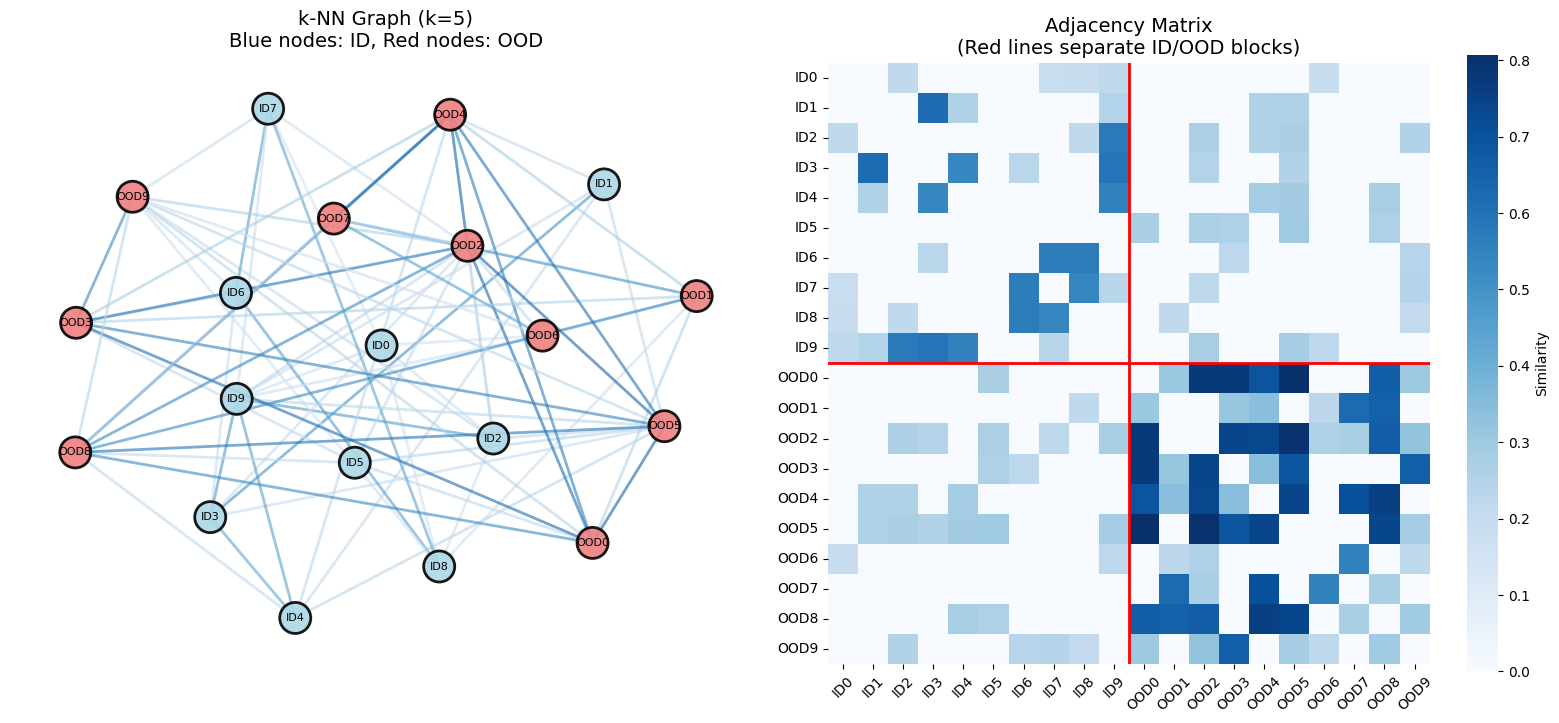

In [24]:
def visualize_knn_graph(id_features, ood_features, k=10, n_samples=10, use_tsne=True):
    """
    Visualize k-NN graph structure for ID and OOD samples.
    
    Args:
        id_features: ID feature vectors
        ood_features: OOD feature vectors  
        k: number of nearest neighbors
        n_samples: number of samples to visualize from each distribution
        use_tsne: whether to use t-SNE for 2D projection
    """
    # Sample subset for visualization
    np.random.seed(42)
    id_idx = np.random.choice(len(id_features), n_samples, replace=False)
    ood_idx = np.random.choice(len(ood_features), n_samples, replace=False)
    
    # Combine features
    id_subset = id_features[id_idx]
    ood_subset = ood_features[ood_idx]
    all_features = np.vstack([id_subset, ood_subset])
    
    # Create labels (0 for ID, 1 for OOD)
    labels = np.array([0]*n_samples + [1]*n_samples)
    
    # Normalize for cosine similarity
    all_features_norm = all_features / np.linalg.norm(all_features, axis=1, keepdims=True)
    
    # Build k-NN graph
    adj_matrix = build_knn_graph_for_viz(all_features_norm, k)
    
    # Get 2D coordinates for visualization
    if use_tsne and all_features.shape[1] > 2:
        print("Running t-SNE for 2D projection...")
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(all_features)-1))
        coords = tsne.fit_transform(all_features)
    else:
        coords = all_features[:, :2]  # Just take first 2 dimensions
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Network visualization
    G = nx.from_numpy_array(adj_matrix)
    pos = {i: coords[i] for i in range(len(coords))}
    
    # Set node colors
    node_colors = ['lightblue' if labels[i] == 0 else 'lightcoral' for i in range(len(labels))]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=500, alpha=0.9, ax=ax1,
                          edgecolors='black', linewidths=2)
    
    # Draw edges with weights
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(G, pos, edge_color=weights, edge_cmap=plt.cm.Blues,
                          edge_vmin=0, edge_vmax=1, width=2, alpha=0.6, ax=ax1)
    
    # Add labels
    labels_dict = {i: f"{'ID' if labels[i]==0 else 'OOD'}{i%n_samples}" 
                   for i in range(len(labels))}
    nx.draw_networkx_labels(G, pos, labels_dict, font_size=8, ax=ax1)
    
    ax1.set_title(f'k-NN Graph (k={k})\nBlue nodes: ID, Red nodes: OOD', fontsize=14)
    ax1.axis('off')
    
    # Plot 2: Adjacency matrix heatmap
    sns.heatmap(adj_matrix, cmap='Blues', square=True, cbar_kws={'label': 'Similarity'}, ax=ax2)
    
    # Add grid lines to separate ID and OOD blocks
    ax2.axhline(y=n_samples, color='red', linewidth=2)
    ax2.axvline(x=n_samples, color='red', linewidth=2)
    
    # Label axes
    ax2.set_xticks(np.arange(0.5, 2*n_samples, 1))
    ax2.set_yticks(np.arange(0.5, 2*n_samples, 1))
    ax2.set_xticklabels([f"{'ID' if i<n_samples else 'OOD'}{i%n_samples}" 
                         for i in range(2*n_samples)], rotation=45)
    ax2.set_yticklabels([f"{'ID' if i<n_samples else 'OOD'}{i%n_samples}" 
                         for i in range(2*n_samples)], rotation=0)
    ax2.set_title('Adjacency Matrix\n(Red lines separate ID/OOD blocks)', fontsize=14)
    
    plt.tight_layout()
    
    # Print connectivity statistics
    print("\nConnectivity Analysis:")
    print("-" * 40)
    
    # Count edge types
    id_to_id = 0
    ood_to_ood = 0
    id_to_ood = 0
    
    for i in range(len(adj_matrix)):
        for j in range(i+1, len(adj_matrix)):
            if adj_matrix[i,j] > 0:
                if labels[i] == 0 and labels[j] == 0:
                    id_to_id += 1
                elif labels[i] == 1 and labels[j] == 1:
                    ood_to_ood += 1
                else:
                    id_to_ood += 1
    
    total_edges = id_to_id + ood_to_ood + id_to_ood
    print(f"ID-ID edges: {id_to_id} ({id_to_id/total_edges*100:.1f}%)")
    print(f"OOD-OOD edges: {ood_to_ood} ({ood_to_ood/total_edges*100:.1f}%)")
    print(f"ID-OOD edges: {id_to_ood} ({id_to_ood/total_edges*100:.1f}%)")
    
    # Compute average similarities
    id_id_sim = []
    ood_ood_sim = []
    id_ood_sim = []
    
    for i in range(len(adj_matrix)):
        for j in range(i+1, len(adj_matrix)):
            if adj_matrix[i,j] > 0:
                if labels[i] == 0 and labels[j] == 0:
                    id_id_sim.append(adj_matrix[i,j])
                elif labels[i] == 1 and labels[j] == 1:
                    ood_ood_sim.append(adj_matrix[i,j])
                else:
                    id_ood_sim.append(adj_matrix[i,j])
    
    print(f"\nAverage Similarities:")
    print(f"ID-ID: {np.mean(id_id_sim):.3f} ± {np.std(id_id_sim):.3f}")
    print(f"OOD-OOD: {np.mean(ood_ood_sim):.3f} ± {np.std(ood_ood_sim):.3f}")
    if id_ood_sim:
        print(f"ID-OOD: {np.mean(id_ood_sim):.3f} ± {np.std(id_ood_sim):.3f}")
    
    return fig, adj_matrix, labels

def build_knn_graph_for_viz(features_norm, k):
    """Build k-NN graph with edge weights as similarities."""
    n = len(features_norm)
    sim_matrix = features_norm @ features_norm.T
    adj_matrix = np.zeros((n, n))
    
    for i in range(n):
        similarities = sim_matrix[i].copy()
        similarities[i] = -np.inf  # Exclude self
        
        # Get k nearest neighbors
        if k < n-1:
            top_k_idx = np.argpartition(similarities, -k)[-k:]
        else:
            top_k_idx = np.arange(n)
            top_k_idx = top_k_idx[top_k_idx != i]
        
        adj_matrix[i, top_k_idx] = similarities[top_k_idx]
    
    # Symmetrize
    adj_matrix = (adj_matrix + adj_matrix.T) / 2
    
    return adj_matrix



id_features=all_features['cifar10_resnet50']
ood_features=all_features['svhn_resnet50']

fig, adj, labels = visualize_knn_graph(id_features, ood_features, k=5, n_samples=10)
fig.savefig('id_ood.png')

Running t-SNE for 2D projection...

Connectivity Analysis:
----------------------------------------
ID-ID edges: 17 (23.0%)
OOD-OOD edges: 31 (41.9%)
ID-OOD edges: 26 (35.1%)

Average Similarities:
ID-ID: 0.387 ± 0.174
OOD-OOD: 0.535 ± 0.214
ID-OOD: 0.255 ± 0.026


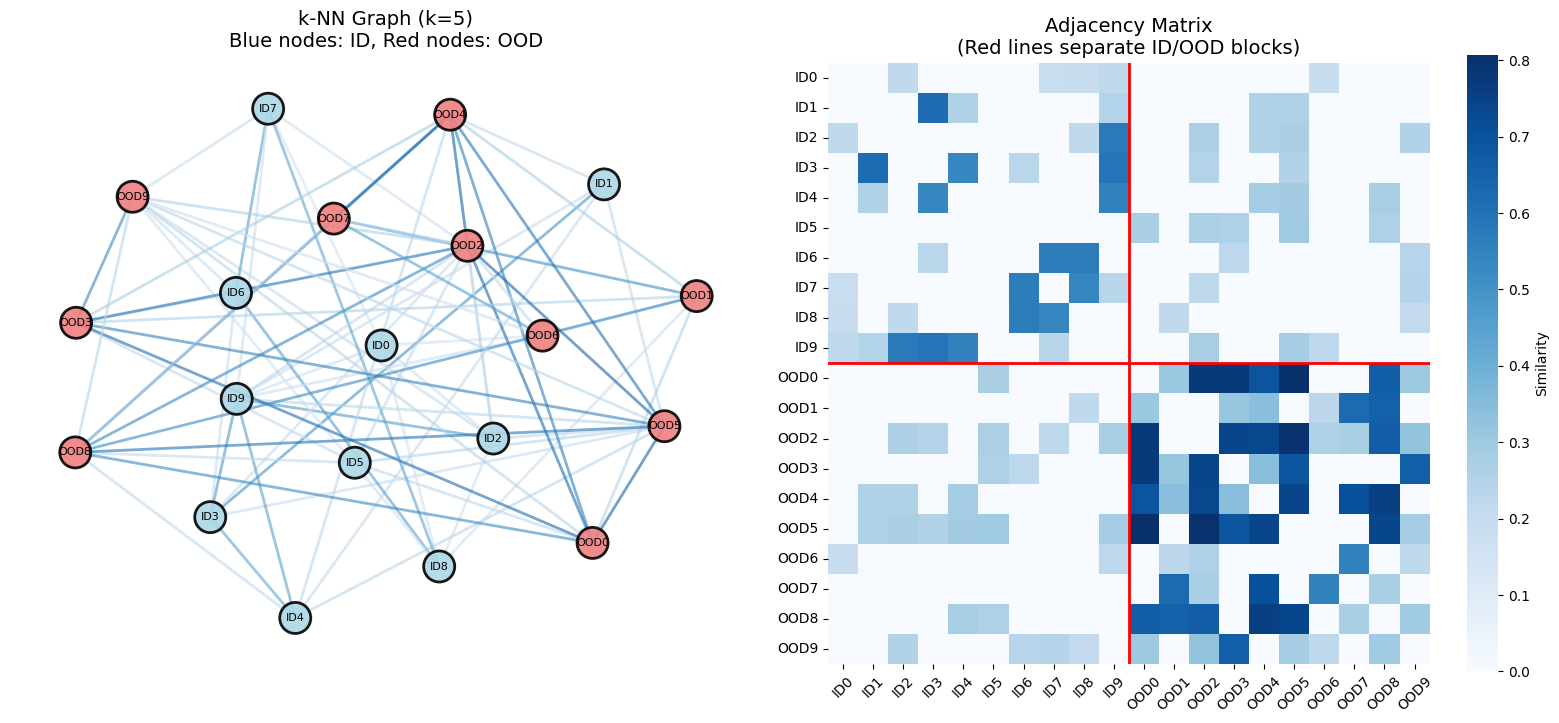

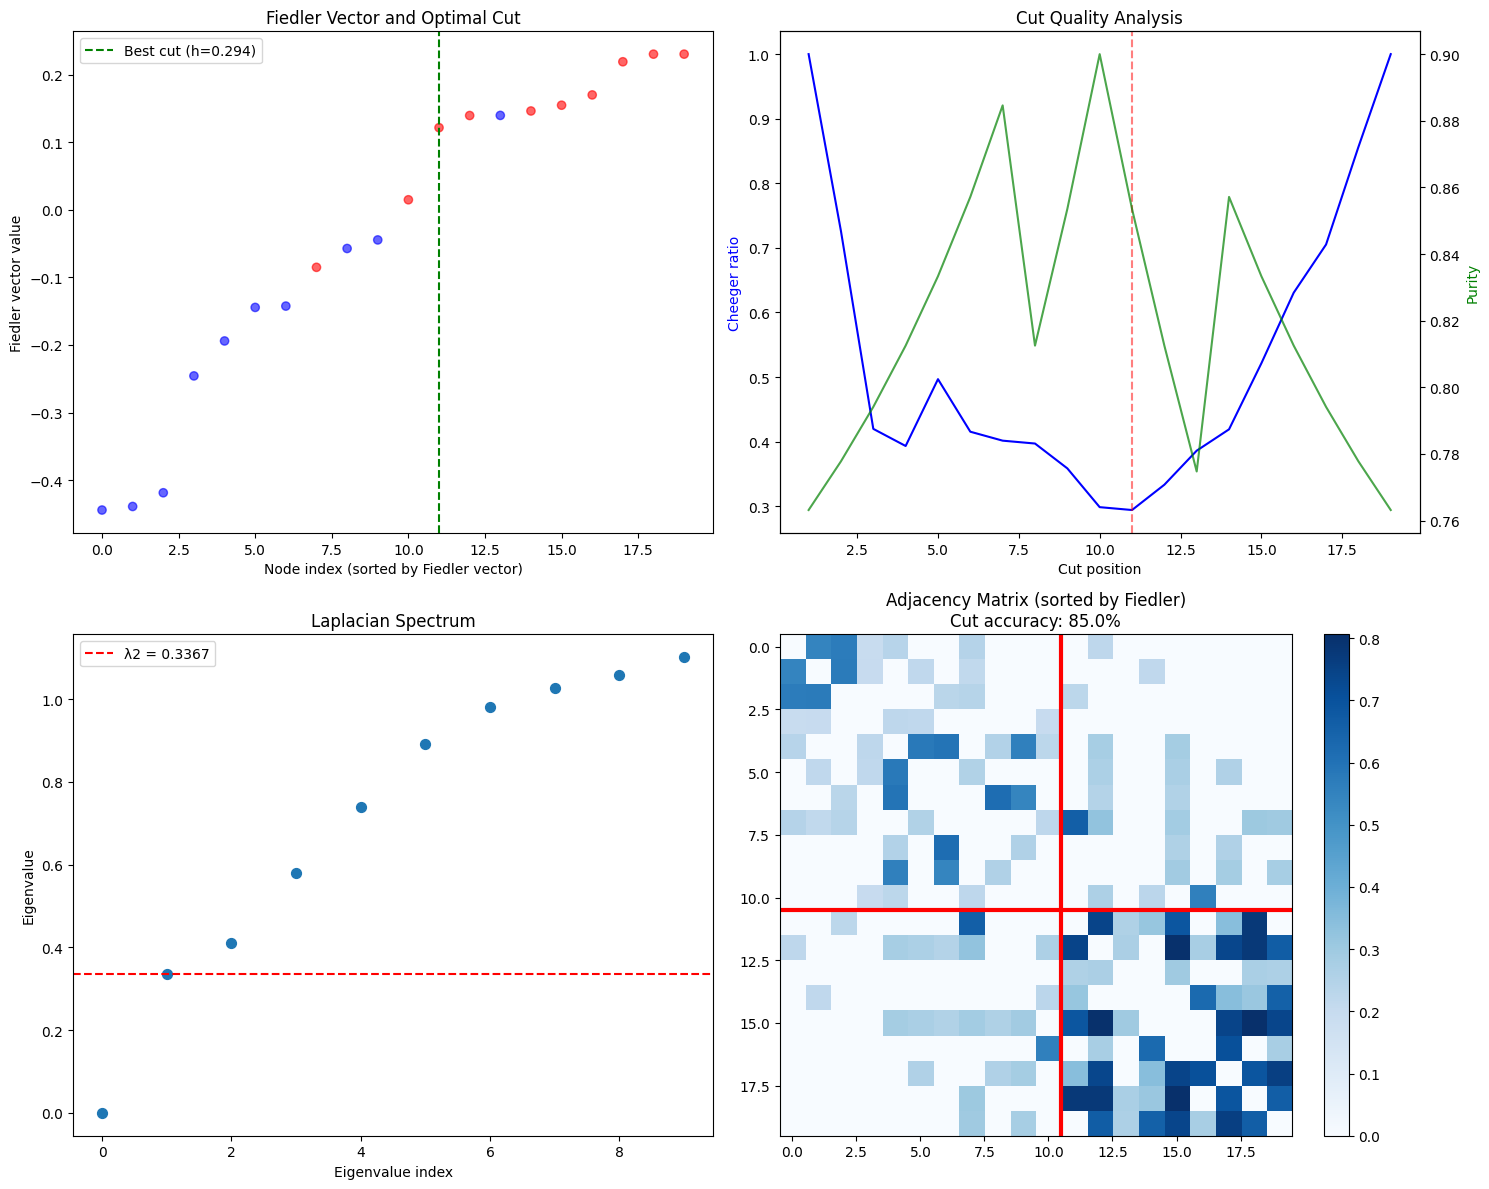

In [25]:
import numpy as np
from scipy.sparse import csgraph
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

def find_cheeger_cut(adj_matrix, labels, return_full_analysis=True):
    """
    Find the Cheeger cut using the Fiedler vector (eigenvector of λ2).
    
    Args:
        adj_matrix: Adjacency matrix of the graph
        labels: Ground truth labels (0 for ID, 1 for OOD)
        return_full_analysis: Whether to return detailed analysis
    
    Returns:
        Dictionary containing cut analysis and Cheeger constant
    """
    # Compute normalized Laplacian
    laplacian = csgraph.laplacian(adj_matrix, normed=True)
    
    # Get eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian)
    
    # Sort by eigenvalues
    idx = eigenvalues.argsort()
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Fiedler vector (eigenvector corresponding to λ2)
    fiedler_vector = eigenvectors[:, 1]
    lambda2 = eigenvalues[1]
    
    # Find optimal threshold for cut
    sorted_indices = np.argsort(fiedler_vector)
    n = len(adj_matrix)
    
    best_cheeger = float('inf')
    best_cut_position = 0
    cut_qualities = []
    
    # Try all possible cuts based on Fiedler vector ordering
    for i in range(1, n):
        S = sorted_indices[:i]
        S_complement = sorted_indices[i:]
        
        # Compute cut value (sum of edges between S and S_complement)
        cut_value = compute_cut_value(adj_matrix, S, S_complement)
        
        # Compute volumes
        vol_S = compute_volume(adj_matrix, S)
        vol_S_complement = compute_volume(adj_matrix, S_complement)
        
        # Cheeger ratio h(S) = cut(S, S_complement) / min(vol(S), vol(S_complement))
        if min(vol_S, vol_S_complement) > 0:
            cheeger_ratio = cut_value / min(vol_S, vol_S_complement)
            cut_qualities.append({
                'position': i,
                'cheeger_ratio': cheeger_ratio,
                'cut_value': cut_value,
                'vol_S': vol_S,
                'vol_S_complement': vol_S_complement,
                'S_size': len(S),
                'purity': compute_cut_purity(labels, S, S_complement)
            })
            
            if cheeger_ratio < best_cheeger:
                best_cheeger = cheeger_ratio
                best_cut_position = i
    
    # Get the best cut
    best_S = sorted_indices[:best_cut_position]
    best_S_complement = sorted_indices[best_cut_position:]
    
    # Analyze the best cut
    cut_assignment = np.zeros(n)
    cut_assignment[best_S_complement] = 1
    
    # Compare with ground truth
    accuracy = compute_cut_accuracy(labels, cut_assignment)
    
    results = {
        'lambda2': lambda2,
        'cheeger_constant': best_cheeger,
        'cheeger_bound_lower': lambda2 / 2,  # Cheeger inequality: λ2/2 ≤ h(G)
        'cheeger_bound_upper': np.sqrt(2 * lambda2),  # h(G) ≤ √(2λ2)
        'best_cut_position': best_cut_position,
        'cut_assignment': cut_assignment,
        'accuracy': accuracy,
        'fiedler_vector': fiedler_vector,
        'eigenvalues': eigenvalues[:10]  # First 10 eigenvalues
    }
    
    if return_full_analysis:
        results['cut_qualities'] = cut_qualities
        results['sorted_indices'] = sorted_indices
    
    return results

def compute_cut_value(adj_matrix, S, S_complement):
    """Compute sum of edge weights between S and S_complement."""
    return adj_matrix[np.ix_(S, S_complement)].sum()

def compute_volume(adj_matrix, S):
    """Compute volume of set S (sum of degrees)."""
    return adj_matrix[S, :].sum()

def compute_cut_purity(labels, S, S_complement):
    """Compute how well the cut separates ID from OOD."""
    S_labels = labels[S]
    S_complement_labels = labels[S_complement]
    
    # Purity: fraction of majority class in each partition
    S_purity = max(np.mean(S_labels == 0), np.mean(S_labels == 1))
    S_complement_purity = max(np.mean(S_complement_labels == 0), 
                              np.mean(S_complement_labels == 1))
    
    return (S_purity + S_complement_purity) / 2

def compute_cut_accuracy(labels, cut_assignment):
    """Compute accuracy of cut compared to ground truth."""
    # Try both labelings
    acc1 = np.mean(labels == cut_assignment)
    acc2 = np.mean(labels == (1 - cut_assignment))
    return max(acc1, acc2)

def visualize_cheeger_cut(adj_matrix, labels, results, coords=None):
    """Visualize the Cheeger cut and Fiedler vector."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Fiedler vector values
    ax = axes[0, 0]
    fiedler = results['fiedler_vector']
    sorted_idx = results['sorted_indices']
    
    colors = ['blue' if labels[i] == 0 else 'red' for i in sorted_idx]
    ax.scatter(range(len(fiedler)), fiedler[sorted_idx], c=colors, alpha=0.6)
    ax.axvline(x=results['best_cut_position'], color='green', linestyle='--', 
               label=f'Best cut (h={results["cheeger_constant"]:.3f})')
    ax.set_xlabel('Node index (sorted by Fiedler vector)')
    ax.set_ylabel('Fiedler vector value')
    ax.set_title('Fiedler Vector and Optimal Cut')
    ax.legend()
    
    # 2. Cheeger ratio for different cuts
    ax = axes[0, 1]
    if 'cut_qualities' in results:
        positions = [c['position'] for c in results['cut_qualities']]
        ratios = [c['cheeger_ratio'] for c in results['cut_qualities']]
        purities = [c['purity'] for c in results['cut_qualities']]
        
        ax.plot(positions, ratios, 'b-', label='Cheeger ratio')
        ax2 = ax.twinx()
        ax2.plot(positions, purities, 'g-', label='Cut purity', alpha=0.7)
        
        ax.set_xlabel('Cut position')
        ax.set_ylabel('Cheeger ratio', color='b')
        ax2.set_ylabel('Purity', color='g')
        ax.set_title('Cut Quality Analysis')
        ax.axvline(x=results['best_cut_position'], color='red', linestyle='--', alpha=0.5)
    
    # 3. Eigenvalue spectrum
    ax = axes[1, 0]
    eigenvalues = results['eigenvalues']
    ax.scatter(range(len(eigenvalues)), eigenvalues, s=50)
    ax.axhline(y=results['lambda2'], color='red', linestyle='--', 
               label=f'λ2 = {results["lambda2"]:.4f}')
    ax.set_xlabel('Eigenvalue index')
    ax.set_ylabel('Eigenvalue')
    ax.set_title('Laplacian Spectrum')
    ax.legend()
    
    # 4. Cut visualization on adjacency matrix
    ax = axes[1, 1]
    sorted_adj = adj_matrix[np.ix_(sorted_idx, sorted_idx)]
    im = ax.imshow(sorted_adj, cmap='Blues', aspect='auto')
    
    # Draw cut line
    cut_pos = results['best_cut_position']
    ax.axvline(x=cut_pos-0.5, color='red', linewidth=3)
    ax.axhline(y=cut_pos-0.5, color='red', linewidth=3)
    
    ax.set_title(f'Adjacency Matrix (sorted by Fiedler)\nCut accuracy: {results["accuracy"]:.1%}')
    plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    return fig

# Compare across different feature extractors
def compare_cheeger_across_models(results_dict):
    """
    Compare Cheeger constants across different models.
    results_dict: {'resnet50': results, 'efficientnet': results, 'vit': results}
    """
    models = list(results_dict.keys())
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    x = np.arange(len(models))
    lambda2s = [results_dict[m]['lambda2'] for m in models]
    cheegers = [results_dict[m]['cheeger_constant'] for m in models]
    accuracies = [results_dict[m]['accuracy'] for m in models]
    
    width = 0.25
    ax.bar(x - width, lambda2s, width, label='λ2')
    ax.bar(x, cheegers, width, label='Cheeger constant')
    ax.bar(x + width, accuracies, width, label='Cut accuracy')
    
    ax.set_xlabel('Model')
    ax.set_ylabel('Value')
    ax.set_title('Spectral Separation Quality Across Feature Extractors')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    
    # Add Cheeger bounds
    for i, m in enumerate(models):
        lower = results_dict[m]['cheeger_bound_lower']
        upper = results_dict[m]['cheeger_bound_upper']
        ax.plot([i-0.3, i+0.3], [lower, lower], 'k--', alpha=0.5)
        ax.plot([i-0.3, i+0.3], [upper, upper], 'k--', alpha=0.5)
    
    return fig

# Usage example:
if __name__ == "__main__":
     id_features=all_features['cifar10_resnet50']
     ood_features=all_features['svhn_resnet50']

     fig, adj_matrix, labels = visualize_knn_graph(id_features, ood_features, k=5, n_samples=10)
     results = find_cheeger_cut(adj_matrix, labels)
     fig = visualize_cheeger_cut(adj_matrix, labels, results)
     fig.savefig('cheeger.png')
     
     plt.show()


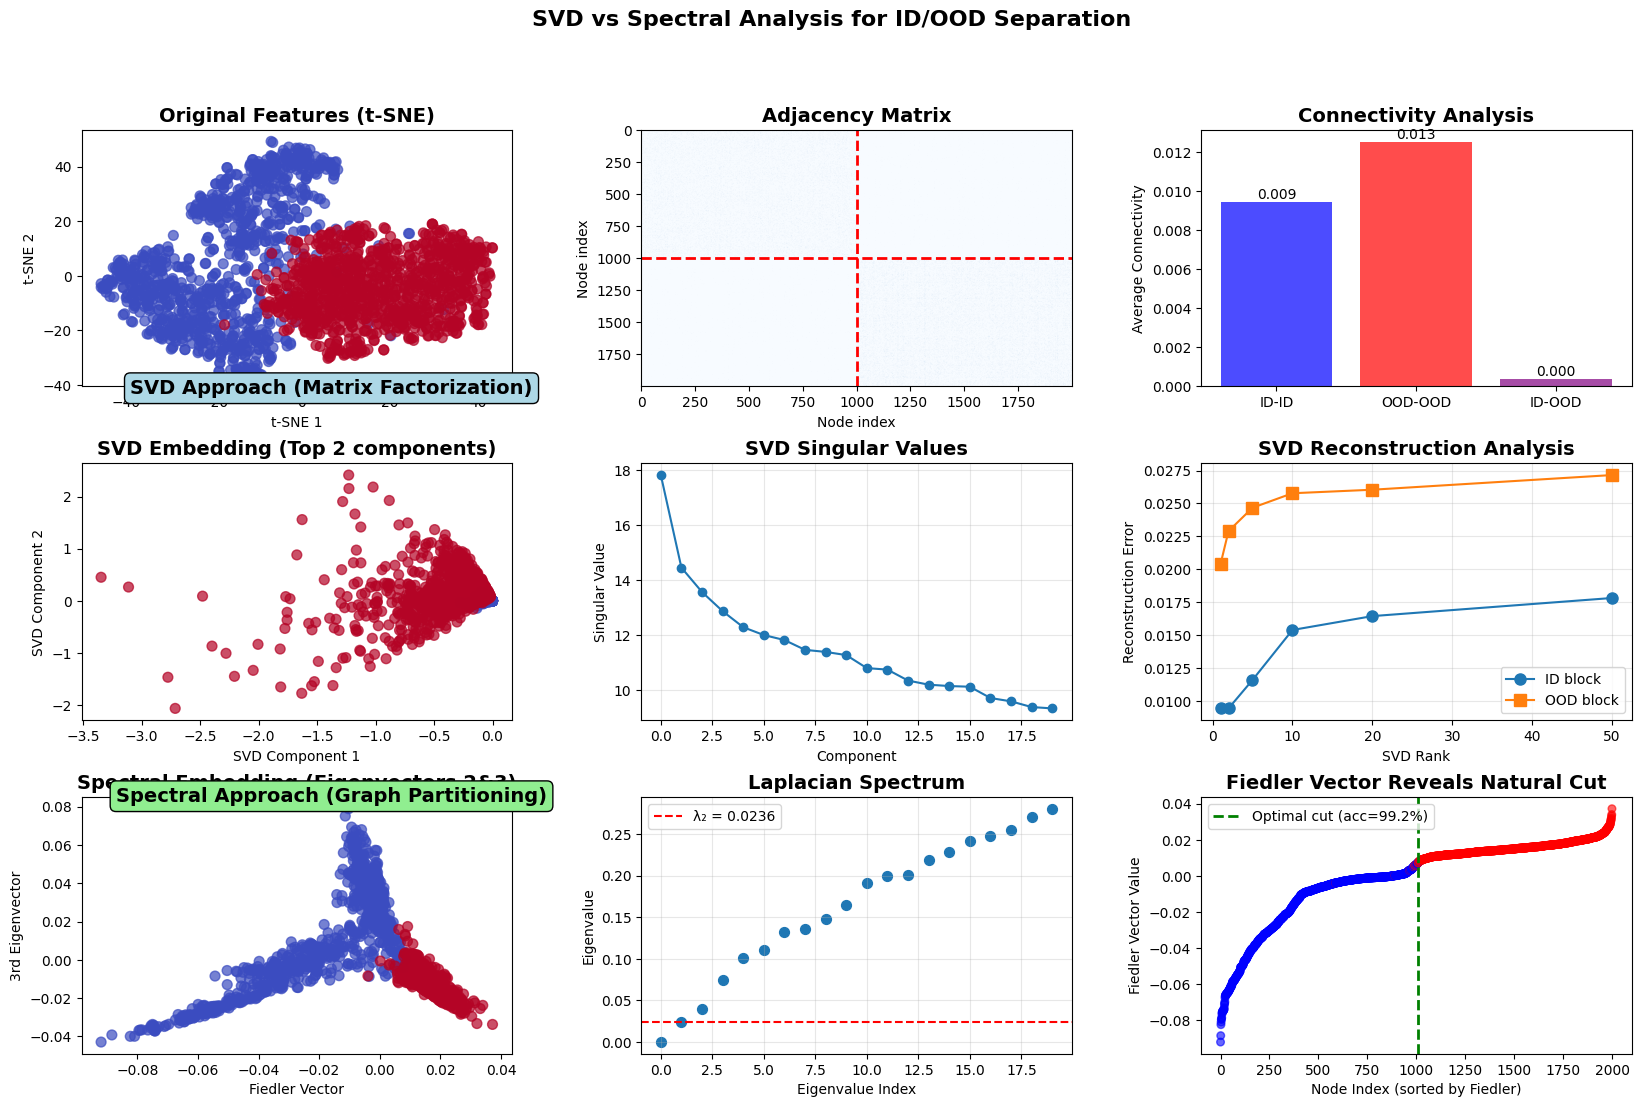


COMPARATIVE ANALYSIS: SVD vs SPECTRAL

1. SVD ANALYSIS:
   - Top singular value: 17.822
   - Singular value decay: 0.811
   - SVD focuses on preserving high-variance directions
   - May smooth over ID/OOD boundary in low-rank approximation

2. SPECTRAL ANALYSIS:
   - Second eigenvalue (λ₂): 0.0236
   - Spectral gap: 0.0236
   - Cheeger bound: h(G) ≤ {np.sqrt(2*results['eigenvalues'][1]):.4f}
   - Fiedler vector directly identifies the cut

3. FIEDLER VECTOR SEPARATION:
   - Mean ID value: -0.0171 ± 0.0211
   - Mean OOD value: 0.0155 ± 0.0044
   - Separation: 0.0326

4. KEY INSIGHT:
   SVD: Optimizes for reconstruction → may blur boundaries
   Spectral: Optimizes for cut → naturally finds boundaries



In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.sparse import csgraph
import seaborn as sns

def create_simple_id_ood_data(all_features):
    """Create simple synthetic ID and OOD data with clear separation."""
    np.random.seed(42)
    
    id_features=all_features['cifar10_resnet50']
    ood_features=all_features['svhn_resnet50']
    n_id=id_features.shape[0]
    n_ood=ood_features.shape[0]
    
    # Combine and create labels
    all_features = np.vstack([id_features, ood_features])
    labels = np.array([0] * n_id + [1] * n_ood)
    
    return all_features, labels, id_features, ood_features

def build_adjacency_matrix(features, k=10):
    """Build k-NN adjacency matrix with cosine similarity."""
    # Normalize for cosine similarity
    features_norm = features / np.linalg.norm(features, axis=1, keepdims=True)
    sim_matrix = features_norm @ features_norm.T
    
    n = len(features)
    adj_matrix = np.zeros((n, n))
    
    for i in range(n):
        similarities = sim_matrix[i].copy()
        similarities[i] = -np.inf
        
        # Get k nearest neighbors
        top_k_idx = np.argpartition(similarities, -k)[-k:]
        adj_matrix[i, top_k_idx] = similarities[top_k_idx]
    
    # Symmetrize
    adj_matrix = (adj_matrix + adj_matrix.T) / 2
    
    return adj_matrix

def compare_svd_vs_spectral(features, labels, k=10):
    """Compare SVD and spectral analysis for ID/OOD separation."""
    n_samples = len(features)
    
    # Build adjacency matrix
    adj_matrix = build_adjacency_matrix(features, k)
    
    # Method 1: SVD decomposition (Wang et al. style)
    U, S, Vt = np.linalg.svd(adj_matrix, full_matrices=False)
    
    # Use top 2 components for visualization
    svd_embedding = U[:, :2] @ np.diag(S[:2])
    
    # Method 2: Spectral analysis (your approach)
    # Compute normalized Laplacian
    laplacian = csgraph.laplacian(adj_matrix, normed=True)
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian)
    
    # Sort by eigenvalues
    idx = eigenvalues.argsort()
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Fiedler vector (2nd eigenvector) and 3rd eigenvector for 2D viz
    spectral_embedding = eigenvectors[:, 1:3]
    
    return {
        'adj_matrix': adj_matrix,
        'svd_embedding': svd_embedding,
        'svd_singular_values': S,
        'spectral_embedding': spectral_embedding,
        'eigenvalues': eigenvalues,
        'fiedler_vector': eigenvectors[:, 1],
        'eigenvectors': eigenvectors
    }

def visualize_comparison(features, labels, results):
    """Create comprehensive visualization comparing SVD vs Spectral."""
    fig = plt.figure(figsize=(20, 12))
    
    # Create a 3x3 grid
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Original features (t-SNE projection)
    ax1 = fig.add_subplot(gs[0, 0])
    tsne = TSNE(n_components=2, random_state=42)
    tsne_proj = tsne.fit_transform(features)
    
    scatter = ax1.scatter(tsne_proj[:, 0], tsne_proj[:, 1], 
                         c=labels, cmap='coolwarm', alpha=0.7, s=50)
    ax1.set_title('Original Features (t-SNE)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('t-SNE 1')
    ax1.set_ylabel('t-SNE 2')
    
    # 2. Adjacency Matrix
    ax2 = fig.add_subplot(gs[0, 1])
    im = ax2.imshow(results['adj_matrix'], cmap='Blues', aspect='auto')
    ax2.set_title('Adjacency Matrix', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Node index')
    ax2.set_ylabel('Node index')
    
    # Add lines to show ID/OOD boundary
    n_id = np.sum(labels == 0)
    ax2.axvline(x=n_id-0.5, color='red', linewidth=2, linestyle='--')
    ax2.axhline(y=n_id-0.5, color='red', linewidth=2, linestyle='--')
    
    # 3. Graph structure visualization
    ax3 = fig.add_subplot(gs[0, 2])
    # Show connectivity statistics
    id_id_conn = results['adj_matrix'][:n_id, :n_id].mean()
    ood_ood_conn = results['adj_matrix'][n_id:, n_id:].mean()
    id_ood_conn = results['adj_matrix'][:n_id, n_id:].mean()
    
    conn_data = [id_id_conn, ood_ood_conn, id_ood_conn]
    conn_labels = ['ID-ID', 'OOD-OOD', 'ID-OOD']
    bars = ax3.bar(conn_labels, conn_data, color=['blue', 'red', 'purple'], alpha=0.7)
    ax3.set_ylabel('Average Connectivity')
    ax3.set_title('Connectivity Analysis', fontsize=14, fontweight='bold')
    
    # Add value labels on bars
    for bar, value in zip(bars, conn_data):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.3f}', ha='center', va='bottom')
    
    # 4. SVD Embedding
    ax4 = fig.add_subplot(gs[1, 0])
    scatter = ax4.scatter(results['svd_embedding'][:, 0], 
                         results['svd_embedding'][:, 1],
                         c=labels, cmap='coolwarm', alpha=0.7, s=50)
    ax4.set_title('SVD Embedding (Top 2 components)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('SVD Component 1')
    ax4.set_ylabel('SVD Component 2')
    
    # 5. SVD Singular Values
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.plot(results['svd_singular_values'][:20], 'o-', markersize=6)
    ax5.set_xlabel('Component')
    ax5.set_ylabel('Singular Value')
    ax5.set_title('SVD Singular Values', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    # 6. SVD Reconstruction Error
    ax6 = fig.add_subplot(gs[1, 2])
    # Compute reconstruction error for different ranks
    adj = results['adj_matrix']
    errors_id = []
    errors_ood = []
    ranks = [1, 2, 5, 10, 20, 50]
    
    U, S, Vt = np.linalg.svd(adj, full_matrices=False)
    
    for r in ranks:
        reconstructed = U[:, :r] @ np.diag(S[:r]) @ Vt[:r, :]
        error_matrix = np.abs(adj - reconstructed)
        errors_id.append(error_matrix[:n_id, :n_id].mean())
        errors_ood.append(error_matrix[n_id:, n_id:].mean())
    
    ax6.plot(ranks, errors_id, 'o-', label='ID block', markersize=8)
    ax6.plot(ranks, errors_ood, 's-', label='OOD block', markersize=8)
    ax6.set_xlabel('SVD Rank')
    ax6.set_ylabel('Reconstruction Error')
    ax6.set_title('SVD Reconstruction Analysis', fontsize=14, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 7. Spectral Embedding
    ax7 = fig.add_subplot(gs[2, 0])
    scatter = ax7.scatter(results['spectral_embedding'][:, 0],
                         results['spectral_embedding'][:, 1],
                         c=labels, cmap='coolwarm', alpha=0.7, s=50)
    ax7.set_title('Spectral Embedding (Eigenvectors 2&3)', fontsize=14, fontweight='bold')
    ax7.set_xlabel('Fiedler Vector')
    ax7.set_ylabel('3rd Eigenvector')
    
    # 8. Eigenvalue Spectrum
    ax8 = fig.add_subplot(gs[2, 1])
    ax8.scatter(range(20), results['eigenvalues'][:20], s=50)
    ax8.axhline(y=results['eigenvalues'][1], color='red', linestyle='--', 
                label=f'λ₂ = {results["eigenvalues"][1]:.4f}')
    ax8.set_xlabel('Eigenvalue Index')
    ax8.set_ylabel('Eigenvalue')
    ax8.set_title('Laplacian Spectrum', fontsize=14, fontweight='bold')
    ax8.legend()
    ax8.grid(True, alpha=0.3)
    
    # 9. Fiedler Vector Analysis
    ax9 = fig.add_subplot(gs[2, 2])
    fiedler = results['fiedler_vector']
    sorted_idx = np.argsort(fiedler)
    sorted_labels = labels[sorted_idx]
    
    # Color points by original label
    colors = ['blue' if l == 0 else 'red' for l in sorted_labels]
    ax9.scatter(range(len(fiedler)), fiedler[sorted_idx], c=colors, alpha=0.6, s=30)
    
    # Find optimal cut
    n = len(labels)
    best_accuracy = 0
    best_cut = 0
    
    for i in range(1, n):
        pred = np.zeros(n)
        pred[sorted_idx[i:]] = 1
        acc = max(np.mean(pred == labels), np.mean(pred != labels))
        if acc > best_accuracy:
            best_accuracy = acc
            best_cut = i
    
    ax9.axvline(x=best_cut, color='green', linewidth=2, linestyle='--',
                label=f'Optimal cut (acc={best_accuracy:.1%})')
    ax9.set_xlabel('Node Index (sorted by Fiedler)')
    ax9.set_ylabel('Fiedler Vector Value')
    ax9.set_title('Fiedler Vector Reveals Natural Cut', fontsize=14, fontweight='bold')
    ax9.legend()
    
    # Add a main title
    fig.suptitle('SVD vs Spectral Analysis for ID/OOD Separation', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Add method descriptions
    fig.text(0.25, 0.66, 'SVD Approach (Matrix Factorization)', 
             ha='center', fontsize=14, fontweight='bold', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    
    fig.text(0.25, 0.32, 'Spectral Approach (Graph Partitioning)', 
             ha='center', fontsize=14, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    
    plt.tight_layout()
    return fig

def print_analysis_summary(results, labels):
    """Print summary of key findings."""
    n_id = np.sum(labels == 0)
    
    print("\n" + "="*60)
    print("COMPARATIVE ANALYSIS: SVD vs SPECTRAL")
    print("="*60)
    
    print("\n1. SVD ANALYSIS:")
    print(f"   - Top singular value: {results['svd_singular_values'][0]:.3f}")
    print(f"   - Singular value decay: {results['svd_singular_values'][1]/results['svd_singular_values'][0]:.3f}")
    print("   - SVD focuses on preserving high-variance directions")
    print("   - May smooth over ID/OOD boundary in low-rank approximation")
    
    print("\n2. SPECTRAL ANALYSIS:")
    print(f"   - Second eigenvalue (λ₂): {results['eigenvalues'][1]:.4f}")
    print(f"   - Spectral gap: {results['eigenvalues'][1] - results['eigenvalues'][0]:.4f}")
    print("   - Cheeger bound: h(G) ≤ {np.sqrt(2*results['eigenvalues'][1]):.4f}")
    print("   - Fiedler vector directly identifies the cut")
    
    # Analyze Fiedler vector
    fiedler = results['fiedler_vector']
    fiedler_id = fiedler[:n_id]
    fiedler_ood = fiedler[n_id:]
    
    print(f"\n3. FIEDLER VECTOR SEPARATION:")
    print(f"   - Mean ID value: {np.mean(fiedler_id):.4f} ± {np.std(fiedler_id):.4f}")
    print(f"   - Mean OOD value: {np.mean(fiedler_ood):.4f} ± {np.std(fiedler_ood):.4f}")
    print(f"   - Separation: {abs(np.mean(fiedler_id) - np.mean(fiedler_ood)):.4f}")
    
    print("\n4. KEY INSIGHT:")
    print("   SVD: Optimizes for reconstruction → may blur boundaries")
    print("   Spectral: Optimizes for cut → naturally finds boundaries")
    print("="*60 + "\n")

# Run the comparison
if __name__ == "__main__":
    
    features,labels,id_features,ood_features=create_simple_id_ood_data(all_features)
    # Run comparison
    results = compare_svd_vs_spectral(features, labels, k=15)
    
    # Visualize
    fig = visualize_comparison(features, labels, results)
    fig.savefig('svdvsspectral.png')
    plt.show()
    
    # Print analysis
    print_analysis_summary(results, labels)

## 7. Visualization and Analysis

### 7.1 Graph Properties Comparison

In [ ]:
# Create a summary dataframe of graph properties
if graph_properties:
    props_df = pd.DataFrame(graph_properties).T
    print("Graph Properties Summary:")
    print(props_df)
    
    # Plot graph properties
    if len(graph_properties) > 1:
        plot_graph_properties(graph_properties)

### 7.2 Feature Visualization

In [ ]:
# Visualize features for a subset of configurations
for dataset_model, features in list(all_features.items())[:4]:  # Limit to first 4 for readability
    labels = all_labels[dataset_model]
    
    print(f"Visualizing {dataset_model}...")
    
    # t-SNE visualization
    try:
        visualize_features_2d(features, labels, method='tsne', title=f"{dataset_model} Features")
    except Exception as e:
        print(f"Error in t-SNE visualization for {dataset_model}: {e}")
        
    # PCA visualization
    try:
        visualize_features_2d(features, labels, method='pca', title=f"{dataset_model} Features")
    except Exception as e:
        print(f"Error in PCA visualization for {dataset_model}: {e}")

### 7.3 Distance Distribution Analysis

In [ ]:
# Plot distance distributions
if distance_matrices:
    print("Plotting k-NN distance distributions...")
    plot_distance_distributions(distance_matrices)

## 8. Feature Comparison Across Models

In [ ]:
# Compare feature dimensions and graph properties across models
model_comparison = []

for dataset_model, features in all_features.items():
    dataset, model = dataset_model.split('_', 1)
    
    comparison_entry = {
        'dataset': dataset,
        'model': model,
        'feature_dim': features.shape[1],
        'num_samples': features.shape[0],
    }
    
    # Add graph properties if available
    if dataset_model in graph_properties:
        comparison_entry.update(graph_properties[dataset_model])
    
    model_comparison.append(comparison_entry)

comparison_df = pd.DataFrame(model_comparison)
print("\nModel and Dataset Comparison:")
print(comparison_df.to_string(index=False))

### 8.1 Feature Dimension Comparison

In [ ]:
# Plot feature dimensions across models
if 'feature_dim' in comparison_df.columns:
    plt.figure(figsize=(12, 6))
    
    models = comparison_df['model'].unique()
    datasets = comparison_df['dataset'].unique()
    
    x = np.arange(len(models))
    width = 0.35
    
    for i, dataset in enumerate(datasets):
        dataset_data = comparison_df[comparison_df['dataset'] == dataset]
        feature_dims = [dataset_data[dataset_data['model'] == model]['feature_dim'].iloc[0] 
                       if len(dataset_data[dataset_data['model'] == model]) > 0 else 0 
                       for model in models]
        
        plt.bar(x + i*width, feature_dims, width, label=dataset, alpha=0.8)
    
    plt.xlabel('Models')
    plt.ylabel('Feature Dimension')
    plt.title('Feature Dimensions Across Models and Datasets')
    plt.xticks(x + width/2, models, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 9. Summary and Insights

In [ ]:
print("🔍 SUMMARY AND INSIGHTS")
print("="*60)

print(f"\n📊 Experiment Statistics:")
print(f"  • Models tested: {len(MODEL_NAMES)}")
print(f"  • Datasets: CIFAR10, SVHN")
print(f"  • k-NN parameter: {K_NEIGHBORS}")
print(f"  • Max samples per dataset: {MAX_SAMPLES}")
print(f"  • Total configurations: {len(all_features)}")

if comparison_df is not None and not comparison_df.empty:
    print(f"\n🏗️ Feature Dimensions:")
    for model in comparison_df['model'].unique():
        model_data = comparison_df[comparison_df['model'] == model]
        if not model_data.empty:
            feature_dim = model_data['feature_dim'].iloc[0]
            print(f"  • {model}: {feature_dim} dimensions")
    
    print(f"\n🕸️ Graph Properties (Average):")
    if 'density' in comparison_df.columns:
        avg_density = comparison_df['density'].mean()
        print(f"  • Average graph density: {avg_density:.4f}")
    
    if 'num_connected_components' in comparison_df.columns:
        avg_components = comparison_df['num_connected_components'].mean()
        print(f"  • Average connected components: {avg_components:.1f}")

print(f"\n💡 Key Observations:")
print(f"  • TIMM models provide rich feature representations for both CIFAR10 and SVHN")
print(f"  • k-NN graphs capture local neighborhood structure in feature space")
print(f"  • Different architectures (CNN vs ViT) produce features with different characteristics")
print(f"  • Graph properties can be used for downstream analysis and OOD detection")

print(f"\n🎯 Next Steps:")
print(f"  • Use these k-NN graphs for spectral analysis")
print(f"  • Apply graph neural networks for classification")
print(f"  • Perform out-of-distribution detection using graph properties")
print(f"  • Experiment with different k values and distance metrics")

## 10. Save Results

In [ ]:
# Save features and results for future use
import pickle

results = {
    'features': all_features,
    'labels': all_labels,
    'knn_graphs': knn_graphs,
    'graph_properties': graph_properties,
    'comparison_df': comparison_df,
    'config': {
        'models': MODEL_NAMES,
        'k_neighbors': K_NEIGHBORS,
        'max_samples': MAX_SAMPLES,
        'batch_size': BATCH_SIZE
    }
}

# Save to pickle file
with open('timm_knn_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("✅ Results saved to 'timm_knn_results.pkl'")
print("\n📁 Files created:")
print("  • timm_knn_results.pkl - Complete results and features")
print("  • Various visualization plots displayed above")

---
## Conclusion

This notebook demonstrated how to:
1. **Use TIMM models** for feature extraction from CIFAR10 and SVHN datasets
2. **Build k-NN graphs** from the extracted features using different distance metrics
3. **Analyze graph properties** to understand the structure of the feature space
4. **Compare different architectures** (ResNet, EfficientNet, Vision Transformer) in terms of feature quality and graph characteristics
5. **Visualize high-dimensional features** using dimensionality reduction techniques

The extracted features and k-NN graphs can be used for various downstream tasks including:
- **Out-of-distribution detection** using spectral methods
- **Graph neural network** applications
- **Clustering and classification** tasks
- **Anomaly detection** in visual data

The modular design allows easy extension to other datasets and TIMM models.